In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("D:/Guvi/Projects/Flight/Data/Flight_Price.csv")
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU ? BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU ? BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR ? DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR ? DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [3]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [4]:
#dropping the null values at column level (1 rows is reduced as a result)
df.dropna(subset=["Route", "Total_Stops"], inplace=True)

### Feature engg and cleaning 

In [5]:
df["Additional_Info"].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [6]:
#removing not neccessary columns from the dataset 
df.drop(columns=["Additional_Info", "Route"], inplace=True)

In [7]:
#fixing the date of journey dept and arrival times 

df["Date_of_Journey"] = pd.to_datetime(df["Date_of_Journey"], format='%d/%m/%Y')

In [8]:
df

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,3897
1,Air India,2019-05-01,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,16:50,21:35,4h 45m,1 stop,13302
...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-04-09,Kolkata,Banglore,19:55,22:25,2h 30m,non-stop,4107
10679,Air India,2019-04-27,Kolkata,Banglore,20:45,23:20,2h 35m,non-stop,4145
10680,Jet Airways,2019-04-27,Banglore,Delhi,08:20,11:20,3h,non-stop,7229
10681,Vistara,2019-03-01,Banglore,New Delhi,11:30,14:10,2h 40m,non-stop,12648


In [9]:
df["Dept_date_time"] =  df.apply(
    lambda row:pd.Timestamp.combine(
        row["Date_of_Journey"], pd.to_datetime(row["Dep_Time"], format="%H:%M").time()
    ),axis=1)

In [10]:
#sorting out arrival time anomalies 

from dateutil import parser

def parse_arrival(row):
    journye_year = row["Date_of_Journey"].year
    arrival_raw = row["Arrival_Time"].strip()
    
    try:
        if any (month in arrival_raw for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
        
            arrival_datetime = parser.parse(arrival_raw+ f" {journye_year}")

        else:
            arrival_time = pd.to_datetime(arrival_raw, format='%H:%M').time()
            arrival_datetime = pd.Timestamp.combine(row["Date_of_Journey"], arrival_time)
    
        return arrival_datetime

    except:
        return pd.NaT
#apply functio  
df["Arrival_date_time"] = df.apply(parse_arrival, axis=1)

#mask to fix neg values 
while True:
    mask = df["Arrival_date_time"]< df['Dept_date_time']
    if not mask.any():
        break
    df.loc[mask ,'Arrival_date_time' ] +=pd.Timedelta(days=1)

#cal 
df["Flight_duration"] = df["Arrival_date_time"] - df["Dept_date_time"]
df["Duration_in_hours"] = df["Flight_duration"].dt.total_seconds()/3600

In [11]:
df

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Dept_date_time,Arrival_date_time,Flight_duration,Duration_in_hours
0,IndiGo,2019-03-24,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,3897,2019-03-24 22:20:00,2019-03-25 01:10:00,0 days 02:50:00,2.833333
1,Air India,2019-05-01,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,7662,2019-05-01 05:50:00,2019-05-01 13:15:00,0 days 07:25:00,7.416667
2,Jet Airways,2019-06-09,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,13882,2019-06-09 09:25:00,2019-06-10 04:25:00,0 days 19:00:00,19.000000
3,IndiGo,2019-05-12,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,6218,2019-05-12 18:05:00,2019-05-12 23:30:00,0 days 05:25:00,5.416667
4,IndiGo,2019-03-01,Banglore,New Delhi,16:50,21:35,4h 45m,1 stop,13302,2019-03-01 16:50:00,2019-03-01 21:35:00,0 days 04:45:00,4.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-04-09,Kolkata,Banglore,19:55,22:25,2h 30m,non-stop,4107,2019-04-09 19:55:00,2019-04-09 22:25:00,0 days 02:30:00,2.500000
10679,Air India,2019-04-27,Kolkata,Banglore,20:45,23:20,2h 35m,non-stop,4145,2019-04-27 20:45:00,2019-04-27 23:20:00,0 days 02:35:00,2.583333
10680,Jet Airways,2019-04-27,Banglore,Delhi,08:20,11:20,3h,non-stop,7229,2019-04-27 08:20:00,2019-04-27 11:20:00,0 days 03:00:00,3.000000
10681,Vistara,2019-03-01,Banglore,New Delhi,11:30,14:10,2h 40m,non-stop,12648,2019-03-01 11:30:00,2019-03-01 14:10:00,0 days 02:40:00,2.666667


In [12]:
#handling time stamps to effectively train the model on the price predictions:
df["journey_day"] = df["Date_of_Journey"].dt.day
df["journey_month"] = df["Date_of_Journey"].dt.month
df["journey_year"] = df["Date_of_Journey"].dt.year

df['Dep_hour'] = df['Dept_date_time'].dt.hour
df['Dep_minute'] = df['Dept_date_time'].dt.minute

df["arrival_day"] = df["Arrival_date_time"].dt.day
df["arrival_month"] = df["Arrival_date_time"].dt.month
df["arrival_year"] = df["Arrival_date_time"].dt.year

df['Arrival_hour'] = df['Arrival_date_time'].dt.hour
df['Arrival_minute'] = df['Arrival_date_time'].dt.minute

In [13]:
#dropping the raw time lines 
df.drop(columns=["Date_of_Journey","Dep_Time", "Arrival_Time", "Duration", "Dept_date_time", "Arrival_date_time","Flight_duration"], inplace=True)

In [14]:
df

,Airline,Source,Destination,Total_Stops,Price,Duration_in_hours,journey_day,journey_month,journey_year,Dep_hour,Dep_minute,arrival_day,arrival_month,arrival_year,Arrival_hour,Arrival_minute
0,IndiGo,Banglore,New Delhi,non-stop,3897,2.833333,24,3,2019,22,20,25,3,2019,1,10
1,Air India,Kolkata,Banglore,2 stops,7662,7.416667,1,5,2019,5,50,1,5,2019,13,15
2,Jet Airways,Delhi,Cochin,2 stops,13882,19.000000,9,6,2019,9,25,10,6,2019,4,25
3,IndiGo,Kolkata,Banglore,1 stop,6218,5.416667,12,5,2019,18,5,12,5,2019,23,30
4,IndiGo,Banglore,New Delhi,1 stop,13302,4.750000,1,3,2019,16,50,1,3,2019,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,non-stop,4107,2.500000,9,4,2019,19,55,9,4,2019,22,25
10679,Air India,Kolkata,Banglore,non-stop,4145,2.583333,27,4,2019,20,45,27,4,2019,23,20
10680,Jet Airways,Banglore,Delhi,non-stop,7229,3.000000,27,4,2019,8,20,27,4,2019,11,20
10681,Vistara,Banglore,New Delhi,non-stop,12648,2.666667,1,3,2019,11,30,1,3,2019,14,10


### EDA

In [15]:
import seaborn as sns
import matplotlib.pylab as plt

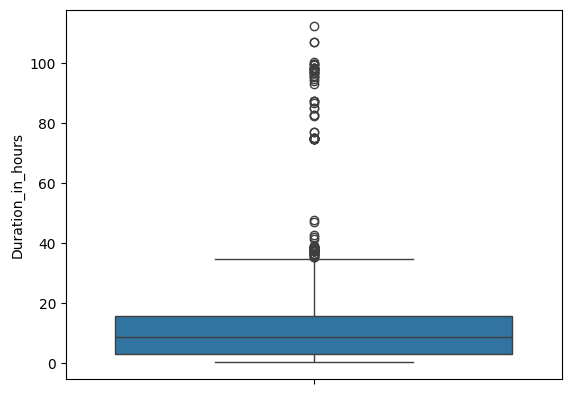

In [16]:
#checking outliers
sns.boxplot(df["Duration_in_hours"])
plt.show()

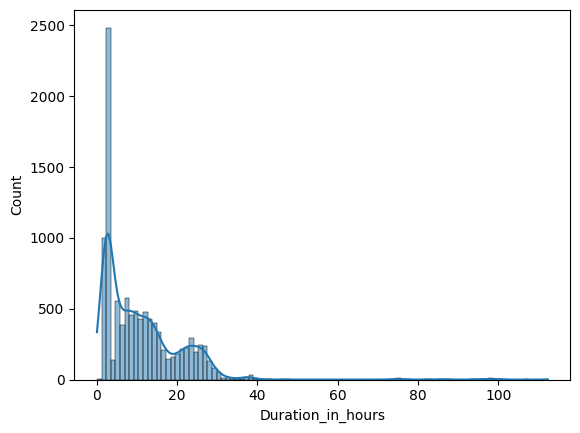

In [17]:
#check skewness for the outliers 
sns.histplot(df["Duration_in_hours"], kde=True)
plt.show()

In [18]:
### The data is positively skewed but since its a real time data it needs no further fixing 

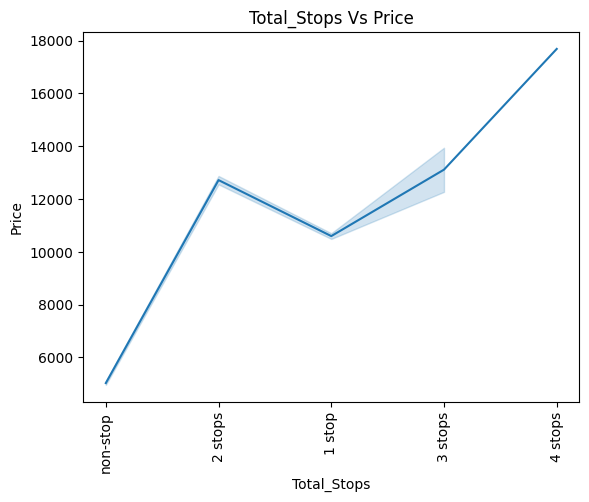

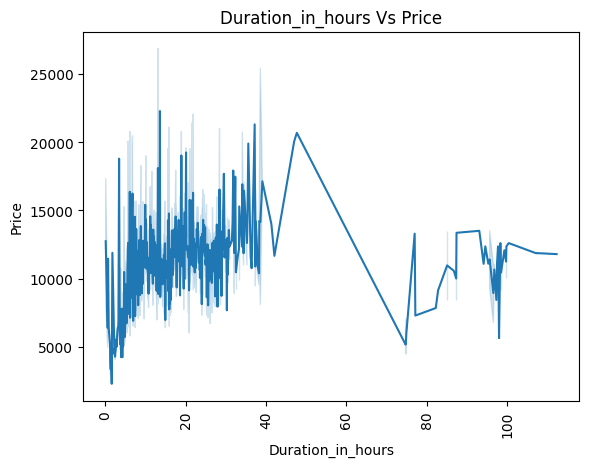

In [19]:
#finding is my data is linear 
#features check 
features=["Total_Stops", "Duration_in_hours",]
for col in features:

    sns.lineplot(x=df[col], y=df["Price"])
    plt.title(f"{col} Vs Price")
    plt.xticks(rotation= 90)
    plt.show()

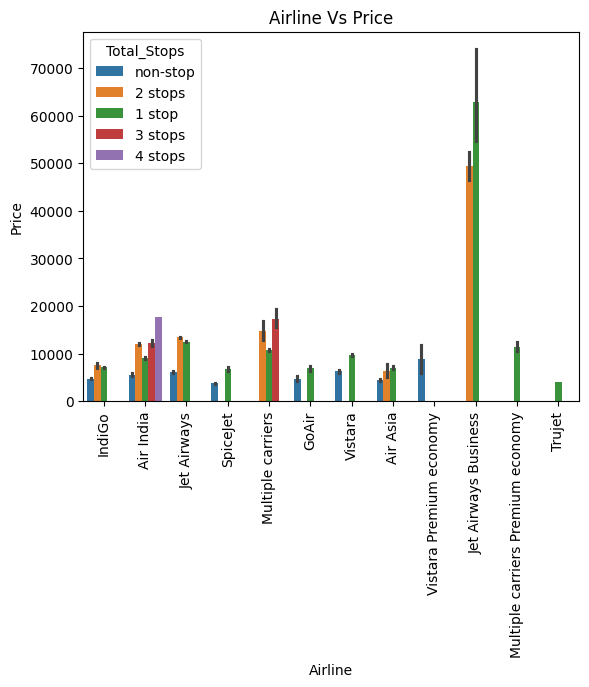

In [20]:
sns.barplot(data=df, x="Airline", y="Price", hue="Total_Stops")
plt.title("Airline Vs Price")
plt.xticks(rotation= 90)
plt.show()

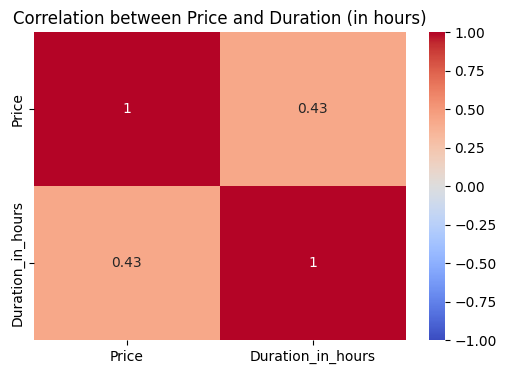

In [21]:
#checking co relation matrix 
import numpy as np
plt.figure(figsize=(6, 4))  # smaller size since it's just 2 variables
corr = df[["Price", "Duration_in_hours"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between Price and Duration (in hours)")
plt.show()

In [22]:
#Price to duration is not very strong relation moderately linear 
#As its non linear the sdandardization is not mandate as the non linear model are scale-invariant

### Encoding

In [23]:
#onhot encoding 
df = pd.get_dummies(df, columns= ["Airline", "Source", "Destination", "Total_Stops"], dtype=int, drop_first=True)
df

,Price,Duration_in_hours,journey_day,journey_month,journey_year,Dep_hour,Dep_minute,arrival_day,arrival_month,arrival_year,...,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Total_Stops_2 stops,Total_Stops_3 stops,Total_Stops_4 stops,Total_Stops_non-stop
0,3897,2.833333,24,3,2019,22,20,25,3,2019,...,0,0,0,0,0,1,0,0,0,1
1,7662,7.416667,1,5,2019,5,50,1,5,2019,...,0,0,0,0,0,0,1,0,0,0
2,13882,19.000000,9,6,2019,9,25,10,6,2019,...,0,1,0,0,0,0,1,0,0,0
3,6218,5.416667,12,5,2019,18,5,12,5,2019,...,0,0,0,0,0,0,0,0,0,0
4,13302,4.750000,1,3,2019,16,50,1,3,2019,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,4107,2.500000,9,4,2019,19,55,9,4,2019,...,0,0,0,0,0,0,0,0,0,1
10679,4145,2.583333,27,4,2019,20,45,27,4,2019,...,0,0,0,0,0,0,0,0,0,1
10680,7229,3.000000,27,4,2019,8,20,27,4,2019,...,0,0,1,0,0,0,0,0,0,1
10681,12648,2.666667,1,3,2019,11,30,1,3,2019,...,0,0,0,0,0,1,0,0,0,1


### Model training (ML)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [25]:
#defining X and Y 
X= df.drop(["Price"], axis=1)
y= df["Price"]

model = [RandomForestRegressor(), DecisionTreeRegressor(), XGBRegressor(), KNeighborsRegressor(), GradientBoostingRegressor()]

#test and train split 
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
for mod in model:
    mod.fit(X_train, y_train)

    train_prediction = mod.predict(X_train)
    test_prediction = mod.predict(X_test)
    
    print(f"The model is :{type(mod).__name__}")
    print("----------------Train---------------")
    print(f"MSE train: {mean_squared_error(y_train, train_prediction)}")
    print(f"MAE train: {mean_absolute_error(y_train, train_prediction)}")
    print(f"R2 train: {r2_score(y_train, train_prediction)}")
    print("--------------Test---------------------")
    print(f"MSE Test: {mean_squared_error(y_test, test_prediction)}")
    print(f"MAE Test: {mean_absolute_error(y_test,test_prediction)}")
    print(f"R2 Test: {r2_score(y_test, test_prediction)}")
    print("\n")


The model is :RandomForestRegressor
----------------Train---------------
MSE train: 974484.2484121266
MAE train: 567.2297901771923
R2 train: 0.9540111042615643
--------------Test---------------------
MSE Test: 3838055.2978766337
MAE Test: 1155.394880422754
R2 Test: 0.8219995699771999


The model is :DecisionTreeRegressor
----------------Train---------------
MSE train: 650610.8875463234
MAE train: 321.4661127364931
R2 train: 0.9692956799225708
--------------Test---------------------
MSE Test: 5170826.528111709
MAE Test: 1348.967438777102
R2 Test: 0.7601886178955279


The model is :XGBRegressor
----------------Train---------------
MSE train: 1400261.875
MAE train: 827.742919921875
R2 train: 0.9339173436164856
--------------Test---------------------
MSE Test: 3504715.0
MAE Test: 1151.427490234375
R2 Test: 0.837459146976471


The model is :KNeighborsRegressor
----------------Train---------------
MSE train: 5876838.467440609
MAE train: 1503.5653364540667
R2 train: 0.7226539967258121
-------

In [27]:
#XGB Regressor has high R2(good prediction score) and low MSE and MAE's and less in overfitting compared to other models 

In [28]:
#checking the performance with tuning : 

from sklearn.model_selection import RandomizedSearchCV

param_dist ={'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1, 10]}

model = XGBRegressor()
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring='r2', random_state=42, n_jobs=1)

random_search.fit(X_train, y_train)

best_param = random_search.best_estimator_
tunned_prediction = best_param.predict(X_test)

print("Best Parameters:", random_search.best_params_)

print("MSE:", mean_squared_error(y_test, test_prediction))
print("MAE:", mean_absolute_error(y_test,test_prediction))
print("R2 Score:", r2_score(y_test, test_prediction))

Best Parameters: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8}
MSE: 4516752.551519272
MAE: 1511.0106400726306
R2 Score: 0.7905231076473009


In [29]:
#no big diff noted in r2 after tunning

In [30]:
#pickling the best model 

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

import pickle

with open("best_model.pkl", "wb") as f:
    pickle.dump(xgb_model,f)

### ML flow

In [37]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Flight_Price_Prediction")

#models 
models = [RandomForestRegressor(), DecisionTreeRegressor(), XGBRegressor(), KNeighborsRegressor(), GradientBoostingRegressor()]

#training and evaluating
for model in models:
    model_name= type(model).__name__

    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)

        prediction = model.predict(X_test)

        mse = mean_squared_error(y_test, prediction)
        mae = mean_absolute_error(y_test, prediction)
        r2 = r2_score(y_test, prediction)

        mlflow.log_metric('MSE', mse)
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('R2',r2)

        mlflow.sklearn.log_model(model, artifact_path=model_name)

        print(f"Logged :{model_name}")


2025/08/15 12:06:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/15 12:06:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged :RandomForestRegressor
🏃 View run RandomForestRegressor at: http://127.0.0.1:5000/#/experiments/434647852206916610/runs/f2c8a06ce52b49a7912fea27c71f9e71
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/434647852206916610


2025/08/15 12:06:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/15 12:06:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged :DecisionTreeRegressor
🏃 View run DecisionTreeRegressor at: http://127.0.0.1:5000/#/experiments/434647852206916610/runs/cd03a5c142424bd4aee968d414eda932
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/434647852206916610


2025/08/15 12:06:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/15 12:07:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged :XGBRegressor
🏃 View run XGBRegressor at: http://127.0.0.1:5000/#/experiments/434647852206916610/runs/e820a19a0974418fbb7d01a38b9a51b4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/434647852206916610


2025/08/15 12:07:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/15 12:07:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged :KNeighborsRegressor
🏃 View run KNeighborsRegressor at: http://127.0.0.1:5000/#/experiments/434647852206916610/runs/83a20288503446d89f79194d635dad8c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/434647852206916610


2025/08/15 12:07:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/15 12:07:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged :GradientBoostingRegressor
🏃 View run GradientBoostingRegressor at: http://127.0.0.1:5000/#/experiments/434647852206916610/runs/5b284889f50344b69efcb9675b205b03
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/434647852206916610


#### Registration 

In [39]:
model_uri = "runs:/e820a19a0974418fbb7d01a38b9a51b4/XGBRegressor"
mlflow.register_model(model_uri=model_uri, name="XGBoostFlightModel")

Registered model 'XGBoostFlightModel' already exists. Creating a new version of this model...
2025/08/15 12:08:07 WARNING mlflow.tracking._model_registry.fluent: Run with id e820a19a0974418fbb7d01a38b9a51b4 has no artifacts at artifact path 'XGBRegressor', registering model based on models:/m-54800cc206174fe68edeba711fe8216e instead
2025/08/15 12:08:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostFlightModel, version 1
Created version '1' of model 'XGBoostFlightModel'.


<ModelVersion: aliases=[], creation_timestamp=1755239887320, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1755239887320, metrics=None, model_id=None, name='XGBoostFlightModel', params=None, run_id='e820a19a0974418fbb7d01a38b9a51b4', run_link='', source='models:/m-54800cc206174fe68edeba711fe8216e', status='READY', status_message=None, tags={}, user_id='', version='1'>